## Identifing Fraud from Enron Email and financial data

In [1]:
import sys
sys.path.append('../tools/')
from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier

/Users/Seven/anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import compress

In [3]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.cross_validation import StratifiedKFold


/Users/Seven/anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Understanding the Dataset and Question

In [4]:
# initialize the list
features_list = ['poi',
                 'salary',
                 'bonus',
                 'long_term_incentive',
                 'deferred_income',
                 'deferral_payments',
                 'loan_advances', 
                 'other',
                 'expenses', 
                 'director_fees',
                 'total_payments',
                 'exercised_stock_options',
                 'restricted_stock',
                 'restricted_stock_deferred',
                 'total_stock_value',
                 'to_messages',
                 'from_messages',
                 'from_this_person_to_poi',
                 'from_poi_to_this_person',
                 'shared_receipt_with_poi']
label = ['poi']
print "There are {} features in the list.".format(len(features_list))

There are 20 features in the list.


#### Data exploration and wrangling

In [5]:
# load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# transform the dictionary to dataframe
df = pd.DataFrame.from_dict(data_dict, orient='index', dtype=np.float)

# reorder dataframe
df = df[features_list]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
poi                          146 non-null float64
salary                       95 non-null float64
bonus                        82 non-null float64
long_term_incentive          66 non-null float64
deferred_income              49 non-null float64
deferral_payments            39 non-null float64
loan_advances                4 non-null float64
other                        93 non-null float64
expenses                     95 non-null float64
director_fees                17 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
to_messages                  86 non-null float64
from_messages                86 non-null float64
from_this_person_to_poi      86 non-null fl

In [6]:
print "No. of data points: '{}' and features: '{}'".\
      format(df.shape[0], df.shape[1])
print "No. of POIs: {}".format(len(df[df['poi'] == 1]))
print "No. of non POIs: {}".format(len(df[df['poi'] == 0]))

No. of data points: '146' and features: '20'
No. of POIs: 18
No. of non POIs: 128


##### missing values

In [7]:
# missing values by feature
df = df.replace('NaN', np.nan)
print "Top 5 features by missing values:\n",\
      df.isnull().sum().sort_values(ascending=False).head()

Top 5 features by missing values:
loan_advances                142
director_fees                129
restricted_stock_deferred    128
deferral_payments            107
deferred_income               97
dtype: int64


In [8]:
# missing values by record
nan_value_row = df.isnull().sum(axis=1)
print "Top 5 records by missing values::\n",\
      nan_value_row.sort_values(ascending=False).head()

Top 5 records by missing values::
LOCKHART EUGENE E                19
GRAMM WENDY L                    17
WROBEL BRUCE                     17
WODRASKA JOHN                    17
THE TRAVEL AGENCY IN THE PARK    17
dtype: int64


In [9]:
df.ix['LOCKHART EUGENE E']

poi                          0.0
salary                       NaN
bonus                        NaN
long_term_incentive          NaN
deferred_income              NaN
deferral_payments            NaN
loan_advances                NaN
other                        NaN
expenses                     NaN
director_fees                NaN
total_payments               NaN
exercised_stock_options      NaN
restricted_stock             NaN
restricted_stock_deferred    NaN
total_stock_value            NaN
to_messages                  NaN
from_messages                NaN
from_this_person_to_poi      NaN
from_poi_to_this_person      NaN
shared_receipt_with_poi      NaN
Name: LOCKHART EUGENE E, dtype: float64

Conclusion: There is no useful information in data point `LOCKHART EUGENE E`. I'm going to remove it from the data set.

In [10]:
df.ix['THE TRAVEL AGENCY IN THE PARK']

poi                               0.0
salary                            NaN
bonus                             NaN
long_term_incentive               NaN
deferred_income                   NaN
deferral_payments                 NaN
loan_advances                     NaN
other                        362096.0
expenses                          NaN
director_fees                     NaN
total_payments               362096.0
exercised_stock_options           NaN
restricted_stock                  NaN
restricted_stock_deferred         NaN
total_stock_value                 NaN
to_messages                       NaN
from_messages                     NaN
from_this_person_to_poi           NaN
from_poi_to_this_person           NaN
shared_receipt_with_poi           NaN
Name: THE TRAVEL AGENCY IN THE PARK, dtype: float64

Conclusion: `THE TRAVEL AGENCY IN THE PARK` is clearly not a person and is not helpful to identify a POI. 

In [11]:
# remove data points: 'LOCKHART EUGENE E' & 'THE TRAVEL AGENCY IN THE PARK'
df = df.drop(['LOCKHART EUGENE E', 'THE TRAVEL AGENCY IN THE PARK'], 0)

In [12]:
# fill na for email features 
email_features = ['to_messages',
                  'from_messages',
                  'from_this_person_to_poi',
                  'from_poi_to_this_person',
                  'shared_receipt_with_poi']
imp = Imputer(missing_values='NaN', strategy='median', axis=0)

df.loc[df[df.poi == 1].index, email_features] =\
imp.fit_transform(df[email_features][df.poi == 1])

df.loc[df[df.poi == 0].index, email_features] =\
imp.fit_transform(df[email_features][df.poi == 0])

In [13]:
# fill na with 0 for financial features
df.ix[:,:15] = df.ix[:,:15].fillna(0)

##### data errors

In [14]:
# validate data by comparing the sum of all payment features with 'total_payments'
payment_features = ['salary',
                    'bonus',
                    'long_term_incentive',
                    'deferred_income',
                    'deferral_payments',
                    'loan_advances',
                    'other',
                    'expenses',
                    'director_fees']
print "Records with payment_features error:"
df[df[payment_features].sum(axis=1) != df.total_payments]

Records with payment_features error:


,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_this_person_to_poi,from_poi_to_this_person,shared_receipt_with_poi
BELFER ROBERT,0.0,0.0,0.0,0.0,0.0,-102500.0,0.0,0.0,0.0,3285.0,102500.0,3285.0,0.0,44093.0,-44093.0,944.0,41.0,6.0,26.5,594.0
BHATNAGAR SANJAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,137864.0,0.0,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0,523.0,29.0,1.0,0.0,463.0


In [15]:
# validate data by comparing the sum of all stock features with 'total_stock_value'
stock_features = ['exercised_stock_options',
                  'restricted_stock',
                  'restricted_stock_deferred']
print "Records with stock_features error:"
df[df[stock_features].sum(axis=1) != df.total_stock_value]

Records with stock_features error:


,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_this_person_to_poi,from_poi_to_this_person,shared_receipt_with_poi
BELFER ROBERT,0.0,0.0,0.0,0.0,0.0,-102500.0,0.0,0.0,0.0,3285.0,102500.0,3285.0,0.0,44093.0,-44093.0,944.0,41.0,6.0,26.5,594.0
BHATNAGAR SANJAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,137864.0,0.0,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0,523.0,29.0,1.0,0.0,463.0


It seems that the numbers were filled in the wrong entry. We'll try to fix `BELFER ROBERT` by shifting them 1 column to the left.

In [16]:
# payment_features
df.ix['BELFER ROBERT','deferred_income'] = -102500.0
df.ix['BELFER ROBERT','deferral_payments'] = 0.0
df.ix['BELFER ROBERT','expenses'] = 3285.0
df.ix['BELFER ROBERT','director_fees'] = 102500.0
df.ix['BELFER ROBERT','total_payments'] = 3285.0
# stock_features
df.ix['BELFER ROBERT','exercised_stock_options'] = 0.0
df.ix['BELFER ROBERT','restricted_stock'] = 44093.0
df.ix['BELFER ROBERT','restricted_stock_deferred'] = -44093.0
df.ix['BELFER ROBERT','total_stock_value'] = 0.0

print "No. of records with payment_features error: ",\
      len(df[df[payment_features].sum(axis=1) != df.total_payments])
print "No. of records with stock_features error: ",\
      len(df[df[payment_features].sum(axis=1) != df.total_payments])

No. of records with payment_features error:  1
No. of records with stock_features error:  1


It works. Let's fix `BHATNAGAR SANJAY` by shifting numbers 1 column to the right.

In [17]:
# payment_features
df.ix['BHATNAGAR SANJAY','other'] = 0.0
df.ix['BHATNAGAR SANJAY','expenses'] = 137864.0
df.ix['BHATNAGAR SANJAY','director_fees'] = 0.0
df.ix['BHATNAGAR SANJAY','total_payments'] = 137864.0
# stock_features
df.ix['BHATNAGAR SANJAY','exercised_stock_options'] = 15456290.0
df.ix['BHATNAGAR SANJAY','restricted_stock'] = 2604490.0
df.ix['BHATNAGAR SANJAY','restricted_stock_deferred'] = -2604490.0
df.ix['BHATNAGAR SANJAY','total_stock_value'] = 15456290.0

print "No. of records with payment_features error: ",\
      len(df[df[payment_features].sum(axis=1) != df.total_payments])
print "No. of records with stock_features error: ",\
      len(df[df[payment_features].sum(axis=1) != df.total_payments])

No. of records with payment_features error:  0
No. of records with stock_features error:  0


##### outliers

In [18]:
# sort data points by sum of outlier variables
outliers = df.quantile(.5) + 1.5 * (df.quantile(.75) - df.quantile(.25))
pd.DataFrame((df[1:] > outliers[1:]).\
             sum(axis=1), columns=['No. of outliers']).\
             sort_values('No. of outliers', ascending=False).head()

,No. of outliers
LAY KENNETH L,13
FREVERT MARK A,13
SKILLING JEFFREY K,12
WHALLEY LAWRENCE G,12
TOTAL,12


The results reflect multiple records with values outside of the quantile boundaries. Based on the facts of the case, this made sense for some of the finance data points and key individuals within Enron. Therefore, the records for actual people will not be removed. However, the TOTAL record is a spreadsheet calculation quirk from the finance data. So this outlier will be removed from the data set.

In [19]:
# remove outliers: 'TOTAL'
df = df.drop('TOTAL')

### Optimize Feature Selection/Engineering

#### create new features

1. `financial_total`: was the features as a total of financial features (total_payments + total_stock_value).
2. `fraction_from_poi`: was to check the fraction of emails received from POI, to all received emails.
3. `fraction_to_poi`: was the fraction of emails sent to POI, to all sent emails.

In [20]:
# create 'financial_total' feature
df['financial_total'] = df['total_payments'] + df['total_stock_value']
# df.financial_total.sort_values(ascending=False).head()

In [21]:
# create 'fraction_from_poi' feature
df['fraction_from_poi'] = df['from_poi_to_this_person']/df['to_messages']
# df.fraction_from_poi.sort_values(ascending=False).head()

In [22]:
# create 'fraction_to_poi' feature
df['fraction_to_poi'] = df['from_this_person_to_poi']/df['from_messages']
# clean 'inf' values caused by denominator with zero value
df = df.replace('inf', 0)
# df.fraction_to_poi.sort_values(ascending=False).head()

In [23]:
# store dataframe with new features_list
features_list = features_list + ['financial_total', 'fraction_from_poi', 'fraction_to_poi']
df = df[features_list]

In [24]:
# extract features and labels from dataset
dataset = df.to_dict('index')
data = featureFormat(dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

#### feature importances

In [25]:
# get feature importances with decision tree
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(df.ix[:,1:], df.ix[:,:1])

features_importance = []
print "Feature importances:"
for i in range(len(dt.feature_importances_)):
    if dt.feature_importances_[i] > 0:
        features_importance.append([df.columns[i+1],
                                    dt.feature_importances_[i]])
features_importance.sort(key=lambda x: x[1], reverse = True)
for f_i in features_importance:
    print f_i
# features_list = [x[0] for x in features_importance]
# features_list.insert(0, 'poi')

Feature importances:
['fraction_to_poi', 0.34628571428571447]
['shared_receipt_with_poi', 0.22013095238095232]
['expenses', 0.16820105820105813]
['other', 0.15642989417989422]
['fraction_from_poi', 0.06128571428571427]
['deferral_payments', 0.047666666666666663]


According to DecisionTree, `fraction_to_poi` we just created got the highest features importance.

#### k-best

In [26]:
# select best k value for k_best
k_best = SelectKBest(score_func=f_classif)
lr = LogisticRegression()
pipe_kbest = Pipeline(steps=[('k_best', k_best),
                             ('clf', lr)])

# test for different values of k
grid = {
    'k_best__k': range(2, len(features_list))
}
search = GridSearchCV(estimator=pipe_kbest,
                      param_grid=grid,
                      scoring='f1',
                      cv=StratifiedKFold(labels, 5))
search.fit(features, labels)
best_param = search.best_estimator_.get_params()

print "Best score: {}".format(search.best_score_)
print "Best k: {}".format(best_param['k_best__k'])

/Users/Seven/anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best score: 0.258330266225
Best k: 4


In [27]:
# k best features
k = best_param['k_best__k']
k_best = SelectKBest(score_func=f_classif,
                     k = k)
k_best.fit(features, labels)
scores = k_best.scores_
features_scored = zip(features_list[1:], scores)
features_sorted = list(reversed(sorted(features_scored,
                                       key=lambda x: x[1])))
print "{} best features:\n{}".format(k, features_sorted[:k])

4 best features:
[('fraction_to_poi', 25.578788236346952), ('total_stock_value', 22.510549090242055), ('exercised_stock_options', 22.348975407306217), ('bonus', 20.792252047181535)]


According to SelectKBest, `fraction_to_poi` is the best feature.

#### ranking with recursive feature elimination and cross-validated

Optimal number of features: 11
[False  True False False False  True False False  True False  True  True
  True  True  True  True  True False  True False False False]
Selected features:
['salary', 'deferral_payments', 'expenses', 'total_payments', 'exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 'to_messages', 'from_messages', 'from_poi_to_this_person']


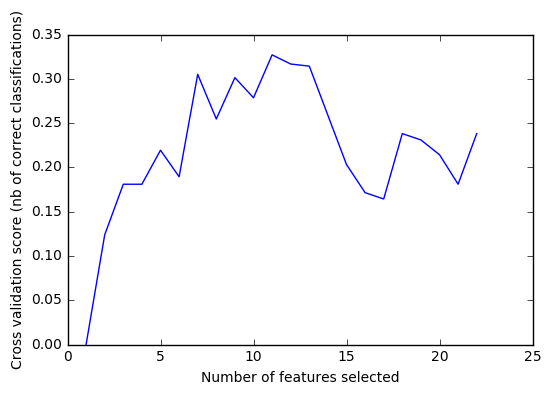

In [28]:
# select the best number of features with RFECV
lr = LogisticRegression()
rfecv = RFECV(estimator=lr, step=1, cv=StratifiedKFold(labels, 5),
          scoring='f1')
rfecv.fit(features, labels)
print "Optimal number of features: {}".format(rfecv.n_features_)
print rfecv.support_

# print new feature list
new_features_list = list(compress(features_list, rfecv.support_))
print "Selected features:\n{}".format(new_features_list)

# plot number of features VS. cross-validation scores
%matplotlib inline
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [29]:
# update data with new features list
features_list_2 = label + new_features_list
df = df[features_list_2]
dataset_2 = df.to_dict('index')
data_2 = featureFormat(dataset_2, features_list_2, sort_keys = True)
labels_2, features_2 = targetFeatureSplit(data_2)

### Pick and Tune an Algorithm

#### Try several algorithms

##### * Naive Bayes

In [30]:
# before RFECV
nb = GaussianNB()
pipe_nb = Pipeline(steps=[('scaler', StandardScaler()),
                          ('pca', PCA()),
                          ('clf', nb)])

test_classifier(pipe_nb, dataset, features_list)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GaussianNB(priors=None))])
	Accuracy: 0.79507	Precision: 0.26133	Recall: 0.29400	F1: 0.27671	F2: 0.28683
	Total predictions: 15000	True positives:  588	False positives: 1662	False negatives: 1412	True negatives: 11338



In [31]:
# after RFECV
test_classifier(pipe_nb, dataset_2, features_list_2)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GaussianNB(priors=None))])
	Accuracy: 0.82380	Precision: 0.28262	Recall: 0.20900	F1: 0.24030	F2: 0.22049
	Total predictions: 15000	True positives:  418	False positives: 1061	False negatives: 1582	True negatives: 11939



##### * Decision Tree

In [32]:
# before RFECV
dt = DecisionTreeClassifier(random_state=42)
pipe_dt = Pipeline(steps=[('scaler', StandardScaler()),
                          ('pca', PCA()),
                          ('clf', dt)])

test_classifier(pipe_dt, dataset, features_list)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         ...        min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])
	Accuracy: 0.82080	Precision: 0.33170	Recall: 0.33900	F1: 0.33531	F2: 0.33751
	Total predictions: 15000	True positives:  678	False positives: 1366	False negatives: 1322	True negatives: 11634



In [33]:
# after RFECV
test_classifier(pipe_dt, dataset_2, features_list_2)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
         ...        min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])
	Accuracy: 0.80347	Precision: 0.30574	Recall: 0.37300	F1: 0.33604	F2: 0.35728
	Total predictions: 15000	True positives:  746	False positives: 1694	False negatives: 1254	True negatives: 11306



##### * Ada Boost

In [34]:
# before RFECV
ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    random_state=42)
pipe_ada = Pipeline(steps=[('scaler', StandardScaler()),
                           ('pca', PCA()),
                           ('clf', ada)])

test_classifier(pipe_ada, dataset, features_list)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifi...e=42,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42))])
	Accuracy: 0.82027	Precision: 0.32789	Recall: 0.33150	F1: 0.32969	F2: 0.33077
	Total predictions: 15000	True positives:  663	False positives: 1359	False negatives: 1337	True negatives: 11641



In [35]:
# after RFECV
test_classifier(pipe_ada, dataset_2, features_list_2)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifi...e=42,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42))])
	Accuracy: 0.80373	Precision: 0.30782	Recall: 0.37800	F1: 0.33932	F2: 0.36151
	Total predictions: 15000	True positives:  756	False positives: 1700	False negatives: 1244	True negatives: 11300



##### * Random Forest

In [36]:
# before RFECV
rf = RandomForestClassifier(random_state=42)
pipe_rf = Pipeline(steps=[('scaler', StandardScaler()),
                          ('pca', PCA()),
                          ('clf', rf)])

test_classifier(pipe_rf, dataset, features_list)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
         ...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])
	Accuracy: 0.86080	Precision: 0.42715	Recall: 0.12900	F1: 0.19816	F2: 0.14993
	Total predictions: 15000	True positives:  258	False positives:  346	False negatives: 1742	True negatives: 12654



In [37]:
# after RFECV
test_classifier(pipe_rf, dataset_2, features_list_2)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
         ...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])
	Accuracy: 0.85007	Precision: 0.32684	Recall: 0.11750	F1: 0.17286	F2: 0.13476
	Total predictions: 15000	True positives:  235	False positives:  484	False negatives: 1765	True negatives: 12516



##### * K-means

In [38]:
# before RFECV
km = KMeans(n_clusters=2, random_state=42)
pipe_km = Pipeline(steps=[('scaler', StandardScaler()),
                          ('pca', PCA()),
                          ('clf', km)])

test_classifier(pipe_km, dataset, features_list)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0))])
	Accuracy: 0.78507	Precision: 0.12222	Recall: 0.09900	F1: 0.10939	F2: 0.10291
	Total predictions: 15000	True positives:  198	False positives: 1422	False negatives: 1802	True negatives: 11578



In [39]:
# after RFECV
test_classifier(pipe_km, dataset_2, features_list_2)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0))])
	Accuracy: 0.66253	Precision: 0.14853	Recall: 0.32350	F1: 0.20359	F2: 0.26182
	Total predictions: 15000	True positives:  647	False positives: 3709	False negatives: 1353	True negatives: 9291



RFECV is more efficient on naive bayes and k-means algorithms, but not on decision tree or decision tree based adaboost and random forest

#### Tune the algorithm

In [40]:
dt = DecisionTreeClassifier(random_state=42)

# create a grid search
grid = {
    'criterion': ('gini', 'entropy'),
    'min_samples_split': range(2, 7),
    'min_samples_leaf': range(1, 7)
}
search = GridSearchCV(estimator=dt, param_grid=grid,
                      scoring='f1',
                      cv=StratifiedKFold(labels, 5))

# fit the search
search.fit(features, labels)

# assign clf with best estimator
clf = search.best_estimator_

# use included tester function to assess performance using cross validation
test_classifier(clf, dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
	Accuracy: 0.90167	Precision: 0.63496	Recall: 0.61750	F1: 0.62611	F2: 0.62092
	Total predictions: 15000	True positives: 1235	False positives:  710	False negatives:  765	True negatives: 12290



### References

* [ENRON - The Smartest Guys in the Room](https://www.youtube.com/watch?v=dbg5J_AjIto)
* [A look at those involved in the Enron scandal](http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm)